In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/gpt-vectorized-pickle/df_vectorized.pkl


In [2]:
# Imports
import os
import pandas as pd
import numpy as np
from collections import Counter
from datetime import date
import ast
import re
import math

# Scikit Learn
from sklearn import set_config
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, MaxAbsScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, LogisticRegression

# Visualizations
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

In [3]:
# Set output of transformers to dataframe
set_config(display='diagram', transform_output='pandas')

In [4]:
# Use the exported data set from above
df = pd.read_pickle('/kaggle/input/gpt-vectorized-pickle/df_vectorized.pkl')

Text(0.5, 1.0, 'Distribution of Missing Values across the Data Set')

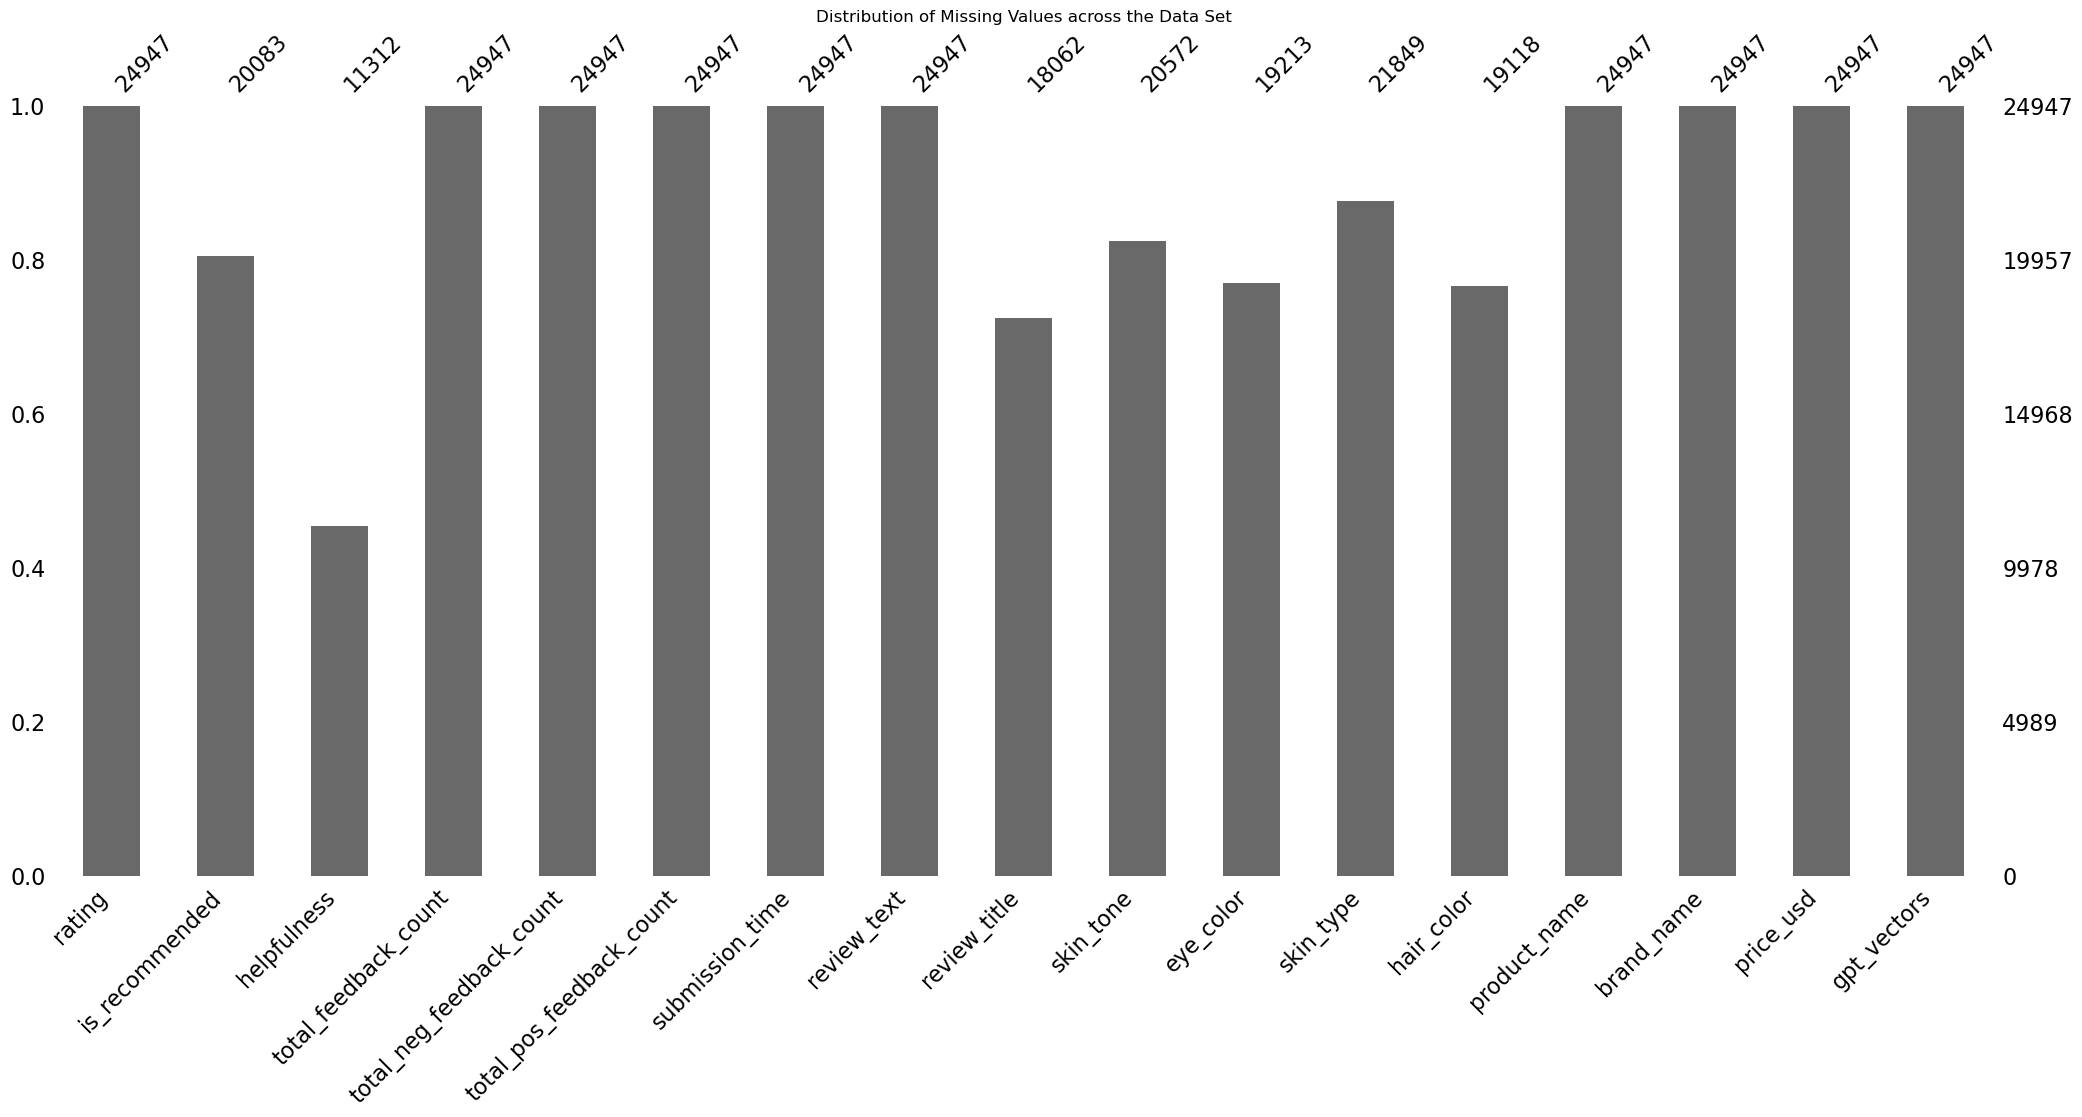

In [5]:
# Visualize the missing values
msno.bar(df)

# Title
plt.title('Distribution of Missing Values across the Data Set')

Text(0.5, 1.0, 'Nullity Correlations')

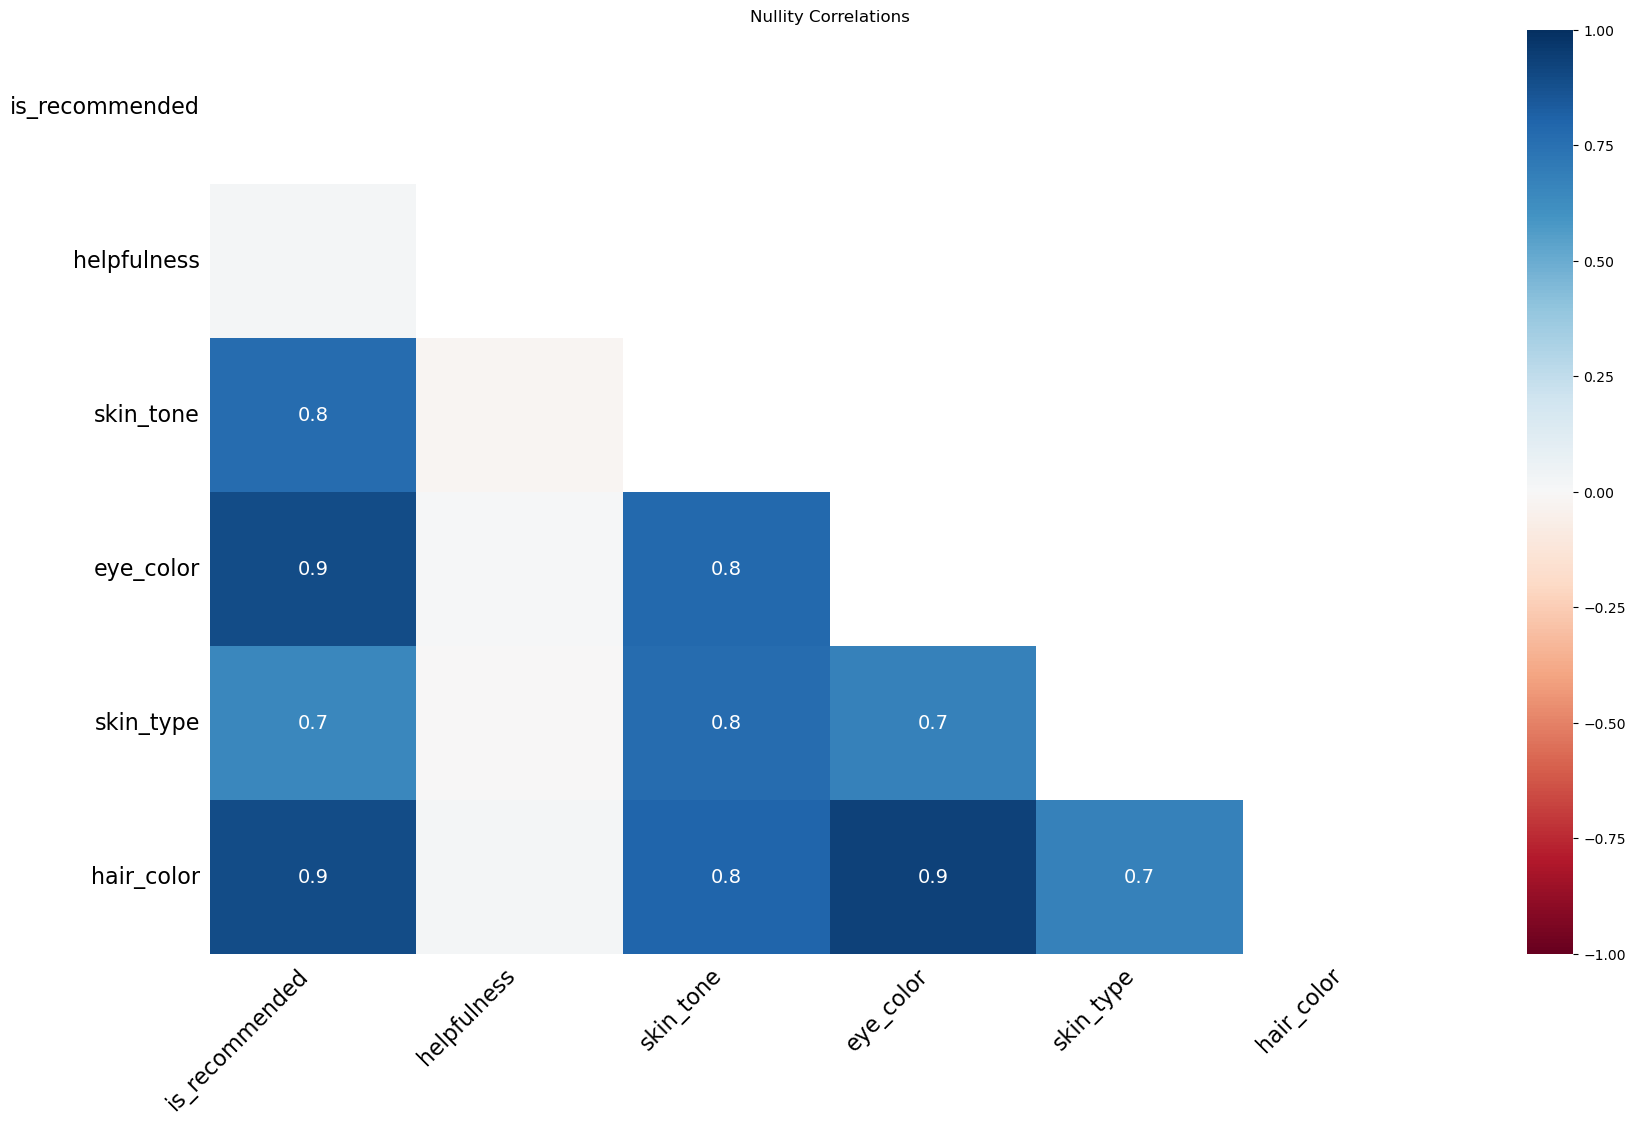

In [6]:
# Correlations among columns with missing values
heatmap_cols = [c for c in df.columns if c != 'review_text' and c != 'review_title']

# Visualize
msno.heatmap(df[heatmap_cols])

# Title
plt.title('Nullity Correlations')

### Remove Outliers based on Price USD

In [7]:
# Price USD - find outliers and remove them from the analysis
df.price_usd.describe()

count    24947.000000
mean        45.423228
std         35.863111
min          3.000000
25%         22.000000
50%         38.000000
75%         58.000000
max        380.000000
Name: price_usd, dtype: float64

Text(0.5, 1.0, 'Price (USD) Boxplot')

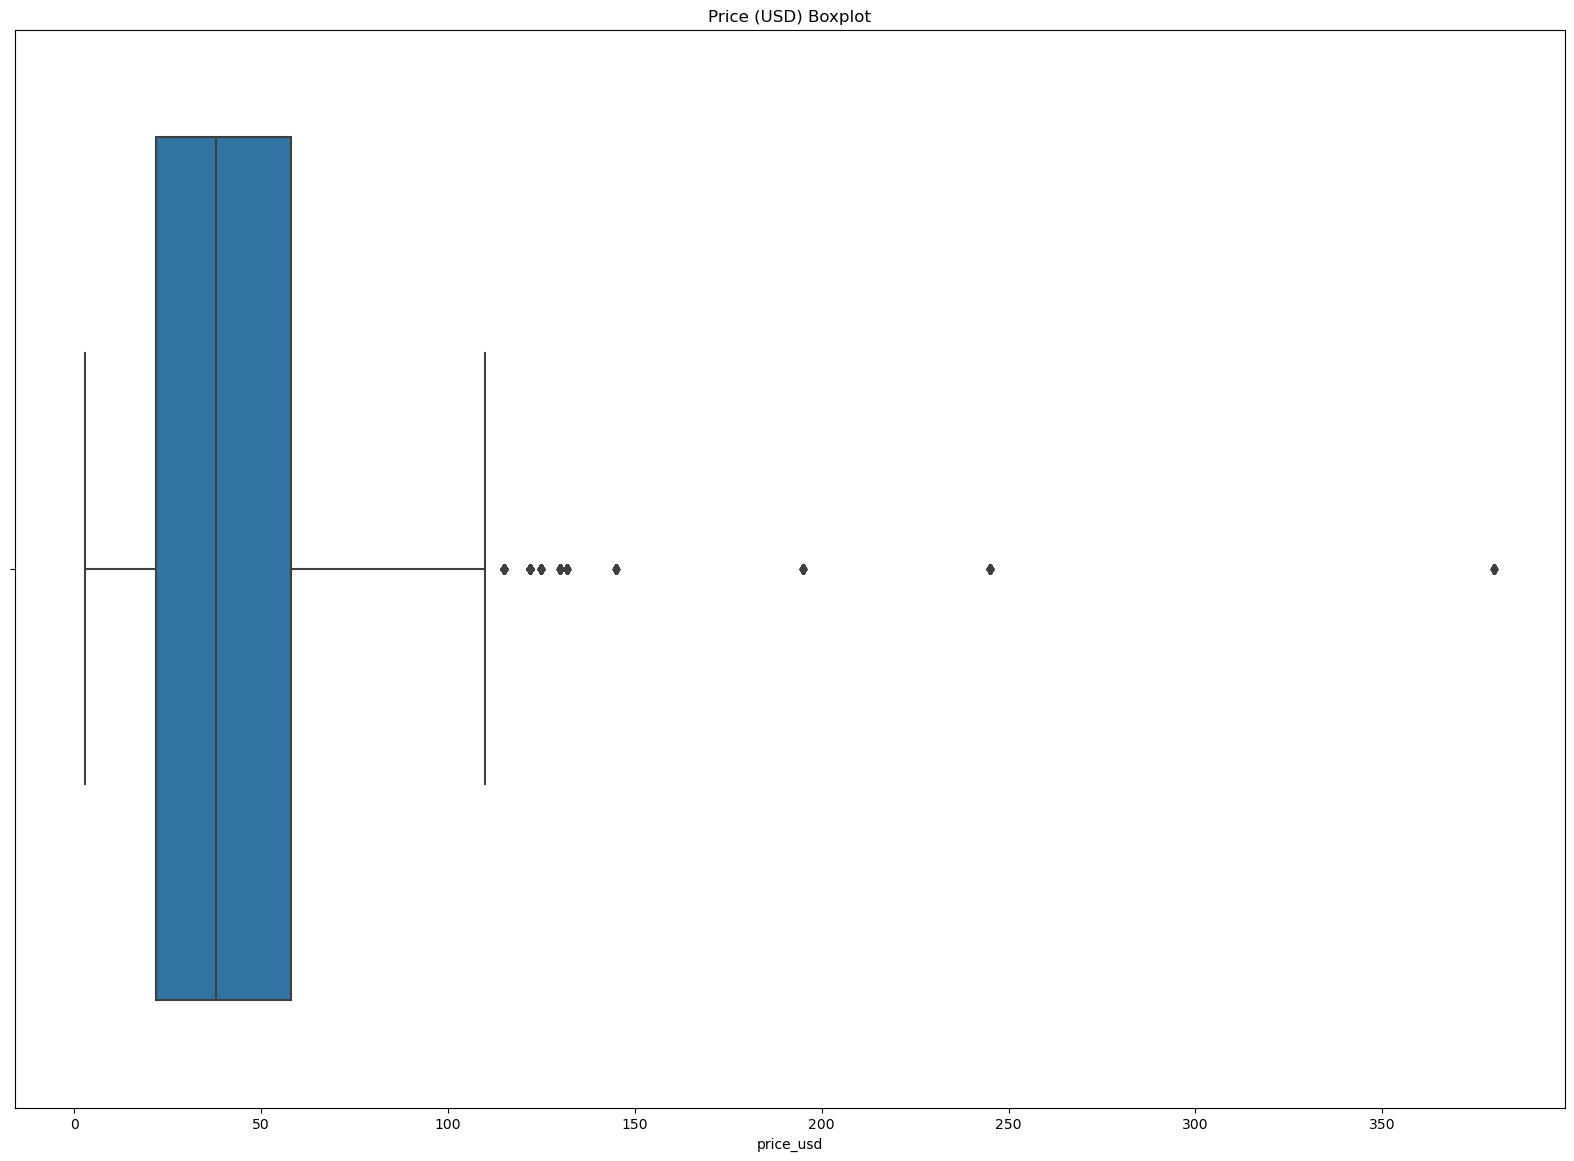

In [8]:
# Boxplot
# Size
plt.figure(figsize=(20,14))

# Boxplot
price_boxes = sns.boxplot(data=df, x='price_usd')

# Titling
plt.title('Price (USD) Boxplot')

In [9]:
# Reset index in df2
df.reset_index(drop=True, inplace=True)

In [10]:
# Identify the outlier values using Tukey's fence method
q1 = df.price_usd.quantile(.25) # First quantile
q3 = df.price_usd.quantile(.75) # Third quantile
iqr = q3-q1 # Interquartile range

# Inner fence lower and upper end
inner_fence_le = q1 - (1.5*iqr)
inner_fence_ue = q3 + (1.5*iqr)
    
# Outer fence lower and upper end
outer_fence_le = q1 - (3*iqr)
outer_fence_ue = q3 + (3*iqr)

# Outlier values
outliers = []

# Only find those that lay outside the outer fence values
for idx, i in enumerate(df.price_usd):
    if i <= outer_fence_le or i >= outer_fence_ue:
        outliers.append(idx)

In [11]:
# Number of outliers
print(f'There are {len(outliers)} outliers in the price variable')

There are 278 outliers in the price variable


In [12]:
# Remove outliers
df = df.drop(index=outliers, axis=1)

# Reset index
df.reset_index(drop=True, inplace=True)

# Check
df.shape

(24669, 17)

## Prepare the Data Set for Linear and Logistic Regressions
- Split into train, validation, and test sets.
- Apply encoders.
- Scale continuous variables.

In [13]:
# For linear regression with price as the target variable
y_linreg = df.price_usd

# For logistic regression with rating as the target variable
y_logreg = df.rating

# Linear Regression and Logistic Regression have same predictor variable
x = df.gpt_vectors

### Split the Data

In [14]:
# Split the data - Linear regression
x_train, x_test_base, ylin_train, ylin_test_base = train_test_split(x, y_linreg, test_size = .20, random_state=42)

# Create validation and test - Linear regression
x_valid, x_test, ylin_valid, ylin_test = train_test_split(x_test_base, ylin_test_base, test_size = .50, random_state = 42)

In [15]:
# Check shapes
print(f'Linear regression training set size: {x_train.shape[0]} | Validation set size: {x_valid.shape[0]} | Test set size: {x_test.shape[0]}')

Linear regression training set size: 19735 | Validation set size: 2467 | Test set size: 2467


### Transform Predictor Variable

In [16]:
# MaxAbsScaler
linreg_maxabs = MaxAbsScaler()

# Transform the y variable
ylin_train = linreg_maxabs.fit_transform(ylin_train.to_numpy().reshape(-1,1))

# Scale validation and test sets
ylin_valid = linreg_maxabs.transform(ylin_valid.to_numpy().reshape(-1,1)) # Validation set
ylin_test = linreg_maxabs.transform(ylin_test.to_numpy().reshape(-1,1)) # Test set

## Linear Regression

This will aim to predict Price (USD).

In [17]:
# Initialize linear regression object
linreg = LinearRegression(n_jobs=-1)

In [18]:
# Fit the model
linreg.fit(x_train.tolist(), ylin_train)

# Model summary
linreg_coef = linreg.coef_
linreg_intercept = linreg.intercept_

In [19]:
# R2
linreg_r2 = linreg.score(x_train.tolist(), ylin_train)

# Show
print(f'Intercept: {linreg_intercept[0]} | No. of Coefficients: {len(linreg_coef[0])} | Score: {linreg_r2}')

Intercept: 0.5359237429069708 | No. of Coefficients: 1536 | Score: 0.393444014485391


In [20]:
# Validation
linreg_val_preds = linreg.predict(x_valid.tolist())

# R2
linreg_val_r2 = linreg.score(x_valid.tolist(), ylin_valid)

# Show
print(f'Score: {linreg_val_r2}')

Score: 0.2974734679021235


In [21]:
# Test
linreg_test_preds = linreg.predict(x_test.tolist())

# R2
linreg_test_r2 = linreg.score(x_test.tolist(), ylin_test)

# Show
print(f'Score: {linreg_test_r2}')

Score: 0.29389210870145954
